In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd

from random import randint
from db.session import get_last_data_by_symbol
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

In [5]:
recordsAll = get_last_data_by_symbol(symbol="xem")
#recordsAll = get_last_data_by_symbol(symbol="xem")

# Convert result to Pandas DataFrame
df = pd.DataFrame(recordsAll.fetchall(), columns=list(recordsAll.keys()))

# Set the timestamp column as the index
df.set_index('created_at', inplace=True)

**Prepare Data**

In [6]:
df["price_change"] = df["lastPrice"].pct_change()
df["volume_change"] = df["volume24h"].pct_change()
df["bid_ask_ratio"] = (df["bid1Size"] / (df["ask1Size"] + 1e-9))

df["mean_price_2"] = df["price_change"].rolling(window=2).mean()
df["mean_price_4"] = df["price_change"].rolling(window=4).mean()
#df["mean_price_8"] = df["price_change"].rolling(window=8).mean()

df["mean_volume_2"] = df["volume_change"].rolling(window=2).mean()
df["mean_volume_4"] = df["volume_change"].rolling(window=4).mean()
#df["mean_volume_8"] = df["volume_change"].rolling(window=8).mean()
df["mean_volume_8_16"] = df["volume_change"].shift(8).rolling(window=8).mean()
df["mean_volume_16_32"] = df["volume_change"].shift(16).rolling(window=16).mean()
df["mean_volume_32_64"] = df["volume_change"].shift(32).rolling(window=32).mean()

df["mean_bid_ask_ratio_4"] = df["bid_ask_ratio"].rolling(window=4).mean()
df["mean_bid_ask_ratio_8_16"] = df["bid_ask_ratio"].shift(8).rolling(window=8).mean()
df["mean_bid_ask_ratio_16_32"] = df["bid_ask_ratio"].shift(16).rolling(window=16).mean()
df["mean_bid_ask_ratio_32_64"] = df["bid_ask_ratio"].shift(32).rolling(window=32).mean()

# Target
lp_shift_3 = df["lastPrice"].shift(-3).rolling(window=3).mean()
lp_shift_3_6 = df["lastPrice"].shift(-6).rolling(window=3).mean()

df["future_return_pcnt_3"] = (lp_shift_3 - df["lastPrice"]) / df["lastPrice"] * 100
df["future_return_pcnt_6"] = (lp_shift_3_6 - df["lastPrice"]) / df["lastPrice"] * 100


df["target_lp_sh_3"] = (df["future_return_pcnt_3"] >= 2).astype(int)
df["target_lp_sh_6"] = (df["future_return_pcnt_6"] >= 5).astype(int)

# Final target combining both conditions*
df["final_target"] = (df["future_return_pcnt_6"] >= 7).astype(int)

skewness = df["lastPrice"].skew()
kurtosis = df["lastPrice"].kurtosis()
min_price = df["lastPrice"].min()
max_price = df["lastPrice"].max()
price_difference = max_price - min_price
percentage_difference_from_min = (price_difference / min_price) * 100
mode_price = df['lastPrice'].mode().iloc[0]

print(f"Skewness of lastPrice: {skewness}")
print(f"Kurtosis of lastPrice: {kurtosis}")
print(f"Minimum of lastPrice: {min_price}")
print(f"Maximum of lastPrice: {max_price}")
print(f"Mode of lastPrice: {mode_price}")
print(f"Percentage Difference from Minimum: {percentage_difference_from_min}%")

# Drop rows with NaN values
df.dropna(inplace=True)

Skewness of lastPrice: -0.5457061059913005
Kurtosis of lastPrice: -0.22114738482960083
Minimum of lastPrice: 0.00157
Maximum of lastPrice: 0.00755
Mode of lastPrice: 0.00174
Percentage Difference from Minimum: 380.89171974522293%


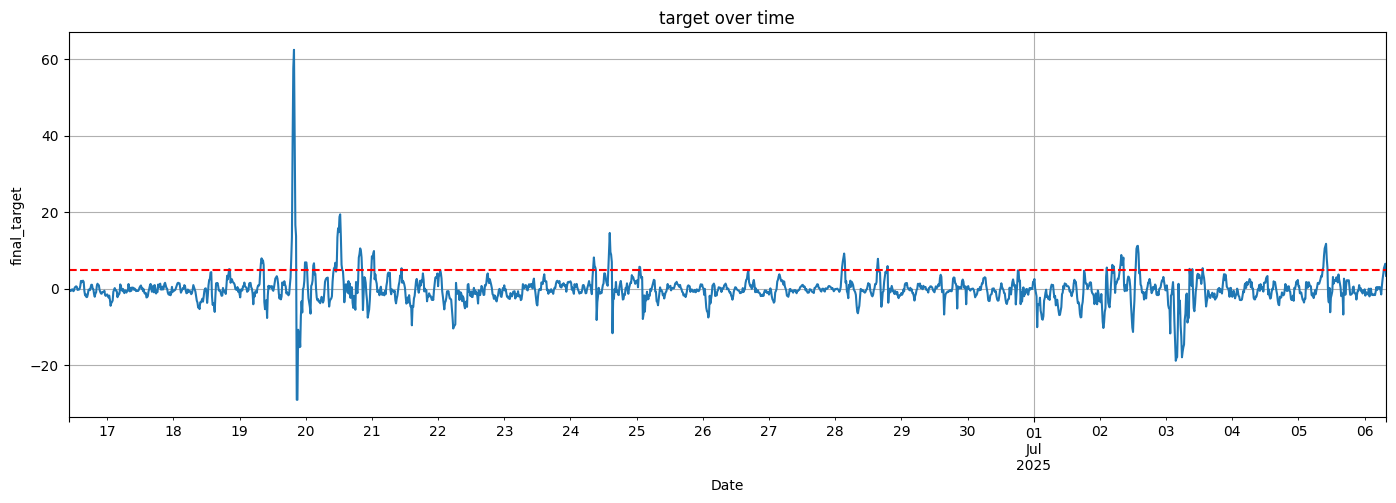

In [180]:
df["future_return_pcnt_6"].plot(figsize=(17, 5), title="target over time")

plt.xlabel("Date")
plt.ylabel("final_target")
plt.grid(True)
# a line at y=5
plt.axhline(y=5, color='r', linestyle='--', label='Threshold 5%')
plt.show()

In [184]:

# Define the columns for scalling
columns_to_scale = ["price_change", "volume_change", "bid_ask_ratio", 
                    "mean_price_2", "mean_price_4","mean_volume_2", "mean_volume_4", 
                    "mean_volume_8_16", "mean_bid_ask_ratio_4", "mean_bid_ask_ratio_8_16",
                    "mean_volume_16_32", "mean_volume_32_64",
                    "mean_bid_ask_ratio_16_32", "mean_bid_ask_ratio_32_64"]

# 1. Select column
df_to_scale = df[columns_to_scale]

# 2. Create and learn the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df_to_scale)

# 3. Return to DataFrame
scaled_df_part = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df.index)
final_scaled_df = pd.concat([scaled_df_part, df["final_target"]], axis=1)


In [185]:
# Prepare tensor data
X = final_scaled_df[columns_to_scale].values
y = final_scaled_df["final_target"].values
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
total = len(y)

print(f"X shape: {X.shape}, y shape: {y.shape}, total samples: {total}")

X shape: torch.Size([1912, 14]), y shape: torch.Size([1912, 1]), total samples: 1912


In [7]:
# Анализируем ваши данные
print(f"Количество признаков: {X.shape[1]}")
print(f"Количество образцов: {X.shape[0]}")
print(f"Соотношение классов: {y.mean():.3f}")

# Правило: параметров должно быть меньше образцов
input_dim = X.shape[1]
samples = X.shape[0]
print(f"Максимальное количество параметров: {samples // 10}")

NameError: name 'X' is not defined

In [187]:
def suggest_hidden_size(input_dim, output_dim, samples):
    """Рекомендации для размера скрытого слоя"""
    
    # Правило 1: 2/3 от входа + выход
    rule1 = int(2/3 * input_dim + output_dim)
    
    # Правило 2: Меньше чем вход
    rule2 = int(input_dim * 0.5)
    
    # Правило 3: Корень из произведения
    rule3 = int((input_dim * output_dim) ** 0.5)
    
    # Правило 4: Степень двойки
    rule4 = 2 ** int(np.log2(input_dim))
    
    print(f"Рекомендации для скрытого слоя:")
    print(f"Правило 2/3+выход: {rule1}")
    print(f"Правило 50% входа: {rule2}")
    print(f"Правило корня: {rule3}")
    print(f"Правило степени 2: {rule4}")
    
    return [rule1, rule2, rule3, rule4]

# Для ваших данных
suggestions = suggest_hidden_size(X.shape[1], 1, X.shape[0])
print(X.shape[1], X.shape[0])

Рекомендации для скрытого слоя:
Правило 2/3+выход: 10
Правило 50% входа: 7
Правило корня: 3
Правило степени 2: 8
14 1912


**Model**

In [188]:
class NetCatcher(nn.Module):
    def __init__(self, input_dim, num_hidden, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.layer2 = nn.Linear(num_hidden, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.tanh(x) # [-1, 1] - это НЕ вероятности!
        x = self.layer2(x)
        x = torch.sigmoid(x)  # Добавляем сигмоиду для получения вероятностей [0, 1]
        return x

In [140]:
class NetCatcherImproved(nn.Module):
    def __init__(self, input_dim, num_hidden, output_dim, dropout=0.2):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.dropout = nn.Dropout(dropout)
        self.layer2 = nn.Linear(num_hidden, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.tanh(x)
        x = self.dropout(x)  # Регуляризация
        x = self.layer2(x)
        x = torch.sigmoid(x)
        return x

**Initialization**

In [189]:
# Пересоздайте модель с правильной инициализацией
model = NetCatcher(input_dim=X.shape[1], num_hidden=16, output_dim=1)
#model = NetCatcherImproved(input_dim=X.shape[1], num_hidden=8, output_dim=1)

# Инициализируем веса
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Проверяем выходы
model.eval()
with torch.no_grad():
    test_outputs = model(X[:10])
    print(f"After init - outputs range: [{test_outputs.min():.3f}, {test_outputs.max():.3f}]")

# Теперь можно обучать
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)


After init - outputs range: [0.571, 0.600]
NetCatcher(
  (layer1): Linear(in_features=14, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=1, bias=True)
)


In [196]:
print(list(model.parameters()))


[Parameter containing:
tensor([[ 13.4440,   6.4800,  -7.5785,   8.1241, -13.9447,  -3.9911, -12.0500,
          18.0214,  -6.9622,  -4.6414, -10.3657, -15.9692, -12.7112,  11.8723],
        [  2.5062,  12.4557,  -6.2693,  -1.5105,  -5.7961,   3.1085,   2.2701,
          -3.2533,   2.2075,   5.2013, -13.8732,   1.4431,  -6.1833,  14.0947],
        [  9.4809,   2.8503,  -1.4985,  -9.5620,  -1.7500,   8.6825,  -3.0874,
          -2.9995,   2.5555,   0.6481, -14.6082,   0.5775,  -2.6325,  16.6183],
        [  8.5187,  10.5760,  -3.4461,   3.9469, -11.7380,  -0.6370,  -5.1496,
           3.3277,   2.4205,   3.4496,  -6.8086, -13.0768,   2.0776,   2.8131],
        [ 10.4740,   0.3639,  -4.0503,  -5.7288,  -3.1256,  -2.7620,  -7.8456,
           7.3996,  -1.4821,   8.4929,  -0.2568,   4.8069,  -3.3809,   2.7959],
        [ -0.9698,   2.0420,   0.9343,   0.6108,   1.0218,   0.3886,  -1.8058,
           0.5105,  -0.4576,   0.2629,  -2.7232,  -3.3204,  -0.1755,   0.3357],
        [ -3.7225,  -9.

**Evaluate**

In [193]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
from datetime import datetime

model.eval()
with torch.no_grad():
    # Получаем предсказания
    raw_outputs = model(X)
    # Несмотря на то, что в вашей модели последним слоем стоит tanh, для задачи бинарной классификации с BCEWithLogitsLoss обычно выход модели должен быть "сырым" (logits), а не вероятностью. 
    # BCEWithLogitsLoss сам внутри применяет сигмоиду, поэтому для получения вероятности для метрик и анализа мы явно применяем torch.sigmoid.
    # Если бы вы использовали nn.Sigmoid() как последний слой, то сигмоиду отдельно применять не нужно было бы.
    # Но у вас tanh, а не sigmoid, поэтому torch.sigmoid(outputs) даст корректную вероятность для бинарной классификации.
    
    # 2. Преобразуем в вероятности
    probabilities = raw_outputs #torch.sigmoid(raw_outputs)
    print(f"Probabilities range: [{probabilities.min():.3f}, {probabilities.max():.3f}]")
    
    # 3. Получаем бинарные предсказания
    predictions = (probabilities > 0.5).float()
    
    # Преобразуем в numpy для sklearn метрик
    y_true = y.cpu().numpy().flatten() if isinstance(y, torch.Tensor) else np.asarray(y).flatten()
    y_pred = predictions.cpu().numpy().flatten()
    y_proba = probabilities.cpu().numpy().flatten()
    
    # Вычисляем метрики
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # ROC AUC только если есть оба класса
    if len(np.unique(y_true)) > 1:
        roc_auc = roc_auc_score(y_true, y_proba)
    else:
        roc_auc = "N/A (only one class present)"
    
    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc}")
    
    print(f"Класс 0: {np.sum(y_true == 0)} ({np.mean(y_true == 0)*100:.1f}%)")
    print(f"Класс 1: {np.sum(y_true == 1)} ({np.mean(y_true == 1)*100:.1f}%)")
    
    print(f"Предсказано 0: {np.sum(y_pred == 0)} ({np.mean(y_pred == 0)*100:.1f}%)")
    print(f"Предсказано 1: {np.sum(y_pred == 1)} ({np.mean(y_pred == 1)*100:.1f}%)")
    print(f"\nМатрица ошибок:")
    print(cm)
    print(f"\nДетальный отчет:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"\nДата: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Probabilities range: [0.000, 1.000]
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0
Класс 0: 1866 (97.6%)
Класс 1: 46 (2.4%)
Предсказано 0: 1866 (97.6%)
Предсказано 1: 46 (2.4%)

Матрица ошибок:
[[1866    0]
 [   0   46]]

Детальный отчет:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1866
         1.0       1.00      1.00      1.00        46

    accuracy                           1.00      1912
   macro avg       1.00      1.00      1.00      1912
weighted avg       1.00      1.00      1.00      1912


Дата: 2025-07-06 13:37:31


[[TN, FP],
 [FN, TP]]
 
TN (True Negative): 
Истинно Отрицательные - Модель правильно предсказала класс 0 (цена не повысится), когда истинный класс тоже был 0.
FP (False Positive): 
Ложноположительные - Модель ошибочно предсказала класс 1 (цена повысится), когда истинный класс был 0.
FN (False Negative): 
Ложноотрицательные - Модель ошибочно предсказала класс 0 (цена не повысится), когда истинный класс был 1. 
TP (True Positive): 
Истинно Положительные - Модель правильно предсказала класс 1 (цена повысится), когда истинный класс тоже был 1.

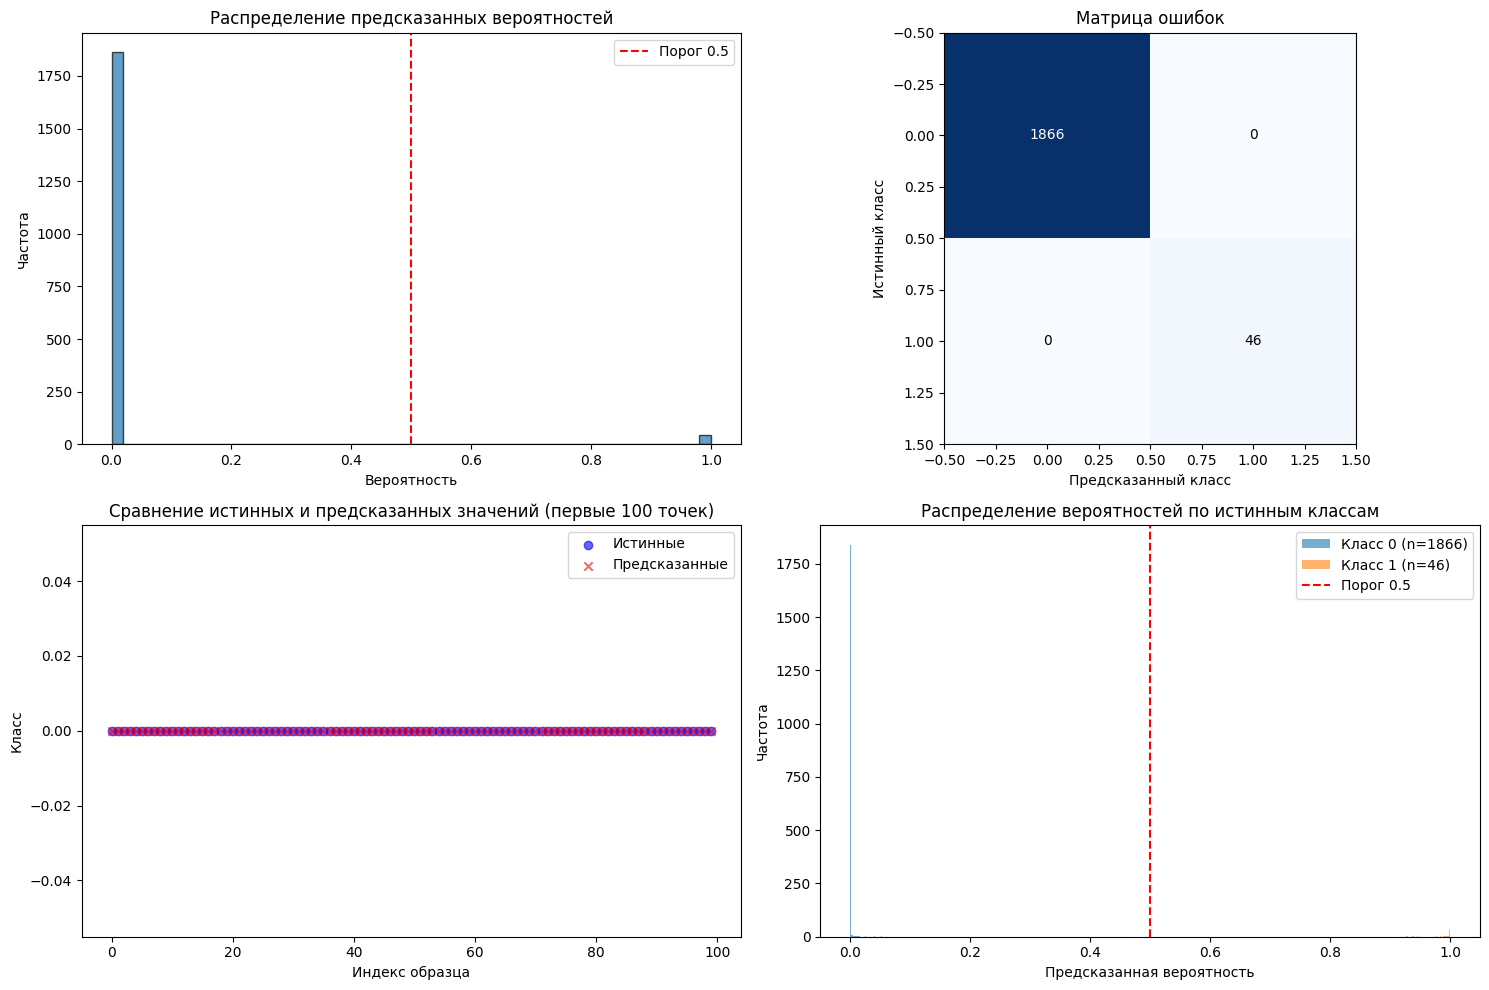

In [194]:
# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Распределение вероятностей
axes[0, 0].hist(y_proba, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Распределение предсказанных вероятностей')
axes[0, 0].set_xlabel('Вероятность')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', label='Порог 0.5')
axes[0, 0].legend()

# 2. Матрица ошибок
im = axes[0, 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0, 1].set_title('Матрица ошибок')
axes[0, 1].set_xlabel('Предсказанный класс')
axes[0, 1].set_ylabel('Истинный класс')
# Добавляем числа в ячейки
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0, 1].text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > cm.max() / 2. else "black")

# 3. Сравнение истинных и предсказанных значений (первые 100 точек)
sample_size = min(100, len(y_true))
x_axis = range(sample_size)
axes[1, 0].scatter(x_axis, y_true[:sample_size], alpha=0.6, label='Истинные', color='blue')
axes[1, 0].scatter(x_axis, y_pred[:sample_size], alpha=0.6, label='Предсказанные', color='red', marker='x')
axes[1, 0].set_title(f'Сравнение истинных и предсказанных значений (первые {sample_size} точек)')
axes[1, 0].set_xlabel('Индекс образца')
axes[1, 0].set_ylabel('Класс')
axes[1, 0].legend()

# 4. Распределение вероятностей по классам
for class_val in [0, 1]:
    mask = y_true == class_val
    if np.sum(mask) > 0:
        axes[1, 1].hist(y_proba[mask], bins=30, alpha=0.6, 
                       label=f'Класс {class_val} (n={np.sum(mask)})')
axes[1, 1].set_title('Распределение вероятностей по истинным классам')
axes[1, 1].set_xlabel('Предсказанная вероятность')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].axvline(x=0.5, color='red', linestyle='--', label='Порог 0.5')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


=== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ===


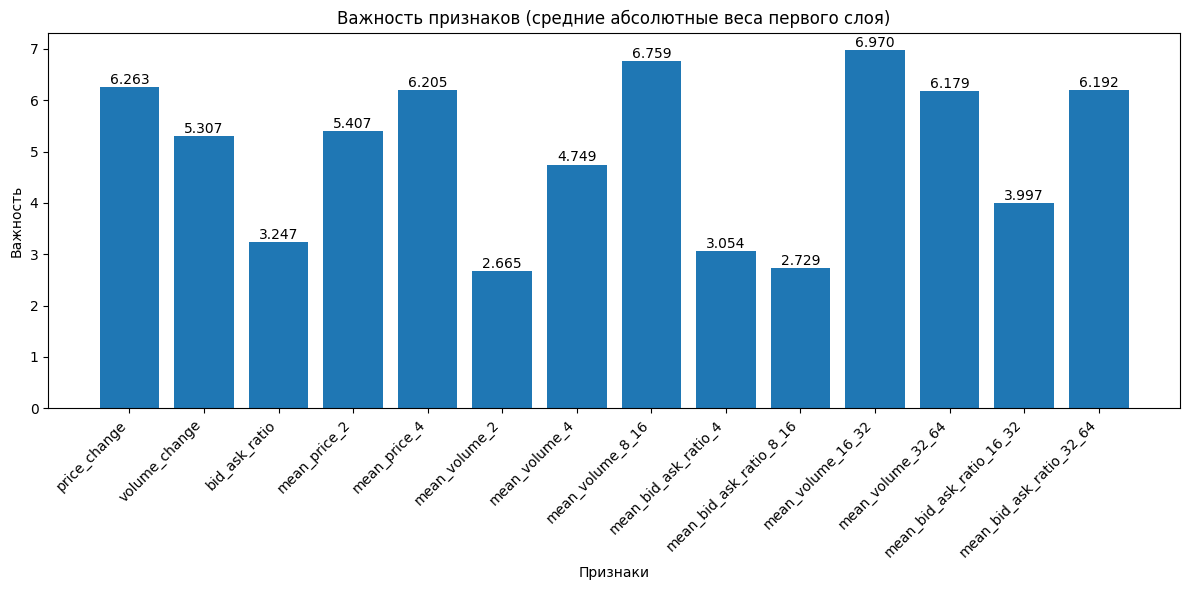


Топ-5 самых важных признаков:
mean_volume_16_32: 6.9704
mean_volume_8_16: 6.7592
price_change: 6.2631
mean_price_4: 6.2049
mean_bid_ask_ratio_32_64: 6.1923

=== ДОПОЛНИТЕЛЬНАЯ ДИАГНОСТИКА ===
Средняя предсказанная вероятность: 0.0240
Стандартное отклонение вероятностей: 0.1522
Минимальная вероятность: 0.0000
Максимальная вероятность: 1.0000
Уникальных значений вероятностей: 68 из 1912
⚠️  Предупреждение: Мало уникальных вероятностей - возможно переобучение!

Ошибки классификации:
Ложноположительные (FP): 0
Ложноотрицательные (FN): 0


In [195]:
# Анализ важности признаков (веса первого слоя)
print("\n=== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ===")
first_layer_weights = model.layer1.weight.data.numpy()
feature_importance = np.abs(first_layer_weights).mean(axis=0)

plt.figure(figsize=(12, 6))
feature_names = columns_to_scale
bars = plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Важность признаков (средние абсолютные веса первого слоя)')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')

# Добавляем значения на столбцы
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{feature_importance[i]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Выводим топ-5 самых важных признаков
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nТоп-5 самых важных признаков:")
for i, row in importance_df.head().iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

# Дополнительная диагностика
print(f"\n=== ДОПОЛНИТЕЛЬНАЯ ДИАГНОСТИКА ===")
print(f"Средняя предсказанная вероятность: {y_proba.mean():.4f}")
print(f"Стандартное отклонение вероятностей: {y_proba.std():.4f}")
print(f"Минимальная вероятность: {y_proba.min():.4f}")
print(f"Максимальная вероятность: {y_proba.max():.4f}")

# Проверяем, есть ли признаки переобучения
unique_probs = len(np.unique(np.round(y_proba, 4)))
total_samples = len(y_proba)
print(f"Уникальных значений вероятностей: {unique_probs} из {total_samples}")
if unique_probs < total_samples * 0.1:
    print("⚠️  Предупреждение: Мало уникальных вероятностей - возможно переобучение!")

# Анализ ошибок
false_positives = np.sum((y_pred == 1) & (y_true == 0))
false_negatives = np.sum((y_pred == 0) & (y_true == 1))
print(f"\nОшибки классификации:")
print(f"Ложноположительные (FP): {false_positives}")
print(f"Ложноотрицательные (FN): {false_negatives}")

if false_positives > 0:
    fp_probs = y_proba[(y_pred == 1) & (y_true == 0)]
    print(f"Средняя вероятность для FP: {fp_probs.mean():.4f}")

if false_negatives > 0:
    fn_probs = y_proba[(y_pred == 0) & (y_true == 1)]
    print(f"Средняя вероятность для FN: {fn_probs.mean():.4f}")

**Training**

In [191]:
for epoch in range(50000):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X)
    
    # Compute loss
    loss = criterion(outputs, y)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}")


Epoch [1/1000], Loss: 0.8925
Epoch [101/1000], Loss: 0.1521
Epoch [201/1000], Loss: 0.1170
Epoch [301/1000], Loss: 0.1127
Epoch [401/1000], Loss: 0.1118
Epoch [501/1000], Loss: 0.1115
Epoch [601/1000], Loss: 0.1112
Epoch [701/1000], Loss: 0.1109
Epoch [801/1000], Loss: 0.1106
Epoch [901/1000], Loss: 0.1104
Epoch [1001/1000], Loss: 0.1101
Epoch [1101/1000], Loss: 0.1098
Epoch [1201/1000], Loss: 0.1095
Epoch [1301/1000], Loss: 0.1092
Epoch [1401/1000], Loss: 0.1089
Epoch [1501/1000], Loss: 0.1087
Epoch [1601/1000], Loss: 0.1085
Epoch [1701/1000], Loss: 0.1083
Epoch [1801/1000], Loss: 0.1081
Epoch [1901/1000], Loss: 0.1079
Epoch [2001/1000], Loss: 0.1077
Epoch [2101/1000], Loss: 0.1075
Epoch [2201/1000], Loss: 0.1073
Epoch [2301/1000], Loss: 0.1071
Epoch [2401/1000], Loss: 0.1069
Epoch [2501/1000], Loss: 0.1068
Epoch [2601/1000], Loss: 0.1066
Epoch [2701/1000], Loss: 0.1064
Epoch [2801/1000], Loss: 0.1061
Epoch [2901/1000], Loss: 0.1059
Epoch [3001/1000], Loss: 0.1057
Epoch [3101/1000], L

**Test**

In [192]:
print(list(model.parameters()))

[Parameter containing:
tensor([[ 13.4440,   6.4800,  -7.5785,   8.1241, -13.9447,  -3.9911, -12.0500,
          18.0214,  -6.9622,  -4.6414, -10.3657, -15.9692, -12.7112,  11.8723],
        [  2.5062,  12.4557,  -6.2693,  -1.5105,  -5.7961,   3.1085,   2.2701,
          -3.2533,   2.2075,   5.2013, -13.8732,   1.4431,  -6.1833,  14.0947],
        [  9.4809,   2.8503,  -1.4985,  -9.5620,  -1.7500,   8.6825,  -3.0874,
          -2.9995,   2.5555,   0.6481, -14.6082,   0.5775,  -2.6325,  16.6183],
        [  8.5187,  10.5760,  -3.4461,   3.9469, -11.7380,  -0.6370,  -5.1496,
           3.3277,   2.4205,   3.4496,  -6.8086, -13.0768,   2.0776,   2.8131],
        [ 10.4740,   0.3639,  -4.0503,  -5.7288,  -3.1256,  -2.7620,  -7.8456,
           7.3996,  -1.4821,   8.4929,  -0.2568,   4.8069,  -3.3809,   2.7959],
        [ -0.9698,   2.0420,   0.9343,   0.6108,   1.0218,   0.3886,  -1.8058,
           0.5105,  -0.4576,   0.2629,  -2.7232,  -3.3204,  -0.1755,   0.3357],
        [ -3.7225,  -9.